# Datasets

## Some publicly available datasets

- [JSRT](https://www.ajronline.org/doi/pdf/10.2214/ajr.174.1.1740071)
	- 247 chest X-rays, 154 have lung nodules. Has lung and heart seg.
	- [Get here](http://db.jsrt.or.jp/eng.php) (register at bottom of page)
- [Montgomery and Shenzhen](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4256233/)
	- Montgomery contains 138 chest X-rays, 80 healthy, 58 tuberculosis. Has lung seg.
	- Shenzhen contains 662 chest X-rays, 326 healthy, 336 tuberculosis. Has lung seg.
	- [Get both here](https://openi.nlm.nih.gov/faq?it=xg#collection). Look for "tuberculosis collection"

That’s 1047 images with lung segmentation label. There are larger datasets that have no segmentation label:

- [NIH ChestX-ray8](https://arxiv.org/abs/1705.02315)
	- 108,948 CXRs of 32,717 patients with eight text-mined disease labels
	- [this might be a way to download](https://nihcc.app.box.com/v/ChestXray-NIHCC)
- [NLST](https://www.nejm.org/doi/10.1056/NEJMoa1102873)
	- There's [this link](https://cdas.cancer.gov/publications/320/), which eventually leads [here](https://cdas.cancer.gov/datasets/nlst/), but I don't see any actual CXR images being made available.
 

### JSRT

See [this guide](JSRT_UsersGuide.pdf) to the data for details.

- `JPCLN***.IMG` for chest lung nodule images, and `JPCNN***.IMG` for non-nodule images. These are important classes to keep in mind for the purpose of proportional train/val/test split.
-  coordinates of the upper left of the image are `(0,0)`
- Image type: 16-bit Unsigned
- Width: 2048 pixels
- Height: 2048 pixels
- Offset to First Image: 0 bytes
- Gap Between Images: 0 bytes

You can load the images using [ImageJ](https://imagej.nih.gov/ij/).
Just import as "RAW" and put in the settings specified by the JSRT guide.

Hmm, stuck on this for now... also where are the segmentations? When I load RAW data into Image J I only see an xray image, and I see no reference to segmentation in the JSRT guide. The JSRT download page doesn't say anything about segmentation labels either.

### Shenzhen

[The readme](NLM-ChinaCXRSet-ReadMe.pdf).

- 336 cases with manifestation of tuberculosis, and 
- 326 normal cases.

- Format: PNG
- Image size varies for each X-ray. It is approximately 3K x 3K.

- Image file names are coded as `CHNCXR_#####_0/1.png`, where ‘0’ represents the normal and ‘1’
represents the abnormal lung. 

Hmm I also cannot find any lung segmentation for this. And [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4256233/) that introduces the dataset seems to suggest that it's just the Montgomery set that has the segmentation.

### Montgomery

[The readme](NLM-MontgomeryCXRSet-ReadMe.pdf).

- 58 cases	with	manifestation	of	tuberculosis,	and	 80 normal	cases.
- Image	 file	 names	are	 coded	as	`MCUCXR_#####_0/1.png`, where	‘0’	 represents	 the	 normal	and	‘1’ represents	the	abnormal	lung. These are important classes to keep in mind for the purpose of proportional train/val/test split.

---

- Format:	PNG
- Matrix	size	is	4020	x	4892,	or	4892	x	4020.
- The	pixel	spacing	in	vertical	and	horizontal	directions	is	0.0875	mm.	
- Number	of	gray	levels	is	12 bits.

---

Segmentation:
> We	manually	generated	the	“gold	standard” segmentations	for	the	chest	X-ray	under	the	supervision	of a	radiologist.	We	used	the	following	conventions	for outlining	the	lung	boundaries:	Both	posterior	and	anterior	ribs	are	readily	visible	in	the	CXRs;	the	part	of	the	lung	behind	the	heart	is	excluded.	We	follow	anatomical	 landmarks	 such	 as	 the	 boundary	 of	 the	 heart,	 aortic	 arc/line,	 and	 pericardium	 line;	 and	sharp	costophrenic	angle	that	follow	the	diaphragm	boundary. We	draw	an	inferred	boundary	when	the	pathology	is	severe	and	affects	the	morphological	appearance	of	the	lungs. The	lung	boundaries	(left	and	right)	are	in	binary	image	format	and	have	the	same	file	name	as	chest	Xrays	( e.g.	`…/left/MCUCXR_#####_0/1.png` or	`…/right/MCUCXR_#####_0/1.png`). 

Looks like this is the one we can actually use here.

In [2]:
import os, glob

dataset_base_path = '/home/ebrahim/data/chest_xrays/MontgomerySet'
dataset_imgs_path = os.path.join(dataset_base_path, 'CXR_png/')
dataset_seg_path_left = os.path.join(dataset_base_path, 'ManualMask/leftMask')
dataset_seg_path_right = os.path.join(dataset_base_path, 'ManualMask/rightMask')

imgs = glob.glob(os.path.join(dataset_imgs_path, '*.png'))
segs_left = glob.glob(os.path.join(dataset_seg_path_left, '*.png'))
segs_right = glob.glob(os.path.join(dataset_seg_path_right, '*.png'))

file_path_to_ID = lambda p : os.path.basename(p)[7:11]
file_path_to_abnormality = lambda p : bool(int(os.path.basename(p)[12]))

img_ids = list(map(file_path_to_ID,imgs));
seg_ids_left = list(map(file_path_to_ID,segs_left));
seg_ids_right = list(map(file_path_to_ID,segs_right));

data = []
for img in imgs:
    img_id = file_path_to_ID(img)
    seg_left = segs_left[seg_ids_left.index(img_id)]
    seg_right = segs_right[seg_ids_right.index(img_id)]
    tuberculosis = file_path_to_abnormality(img)
    data.append({
        'img' : img,
        'seg_left' : seg_left,
        'seg_right' : seg_right,
        'tuberculosis' : tuberculosis

    })

In [3]:
import monai
import matplotlib.pyplot as plt
import numpy as np

In [4]:
data_train, data_valid = monai.data.utils.partition_dataset_classes(
    data,
    classes = list(map(lambda d : d['tuberculosis'], data)),
    ratios = (8,2)
)

In [12]:
# Custom transforms
from typing import Mapping, Hashable, List
import torch

class MasksToOneHotD(monai.transforms.MapTransform):
    def __init__(self, keys: monai.config.KeysCollection,
                 keyList: List[Hashable], newKeyName: str) -> None:
        super().__init__(keys)
        self.keyList = keyList
        self.newKeyName = newKeyName
        assert(len(keyList)>0)

    def __call__(self, data: Mapping[Hashable, np.ndarray]) -> Mapping[Hashable, np.ndarray]:
        
        # (if this were to be contributed, I'd have to pay attention to whether keys are in data)
        # (also I'd want to raise more clear exceptions than these asserts)
        
        assert(all(key in self.keys for key in self.keyList))
        assert(all(key in data.keys() for key in self.keyList))
        assert(self.newKeyName not in data.keys())
        
        data[self.newKeyName] = torch.stack(
            [data[key] for key in self.keyList],
            dim=len(data[self.keyList[0]].shape)
        )
        
        return data


In [89]:
transform_valid = monai.transforms.Compose([
    monai.transforms.LoadImageD(keys = ['img']),
    monai.transforms.LoadImageD(keys = ['seg_left', 'seg_right'], dtype="int8"),
    monai.transforms.ToTensorD(keys = ['img', 'seg_left', 'seg_right']),
    monai.transforms.TransposeD(keys = ['img', 'seg_left', 'seg_right'], indices = (1,0)),
    MasksToOneHotD(
        keys = ['seg_left', 'seg_right'],
        keyList = ['seg_left', 'seg_right'],
        newKeyName = 'seg'
    ),
    monai.transforms.DeleteItemsD(keys = ['seg_left', 'seg_right']),
])

# TODO: add some more transforms for the sake of augmentation
transform_train = transform_valid

In [90]:
# TODO: switch back to CacheDataset once ready to start training

# dataset_train = monai.data.CacheDataset(data_train, transform_train)
# dataset_valid = monai.data.CacheDataset(data_valid, transform_valid)
dataset_train = monai.data.Dataset(data_train, transform_train)
dataset_valid = monai.data.Dataset(data_valid, transform_valid)

In [91]:
dataset_train[0].keys()

dict_keys(['img', 'tuberculosis', 'img_meta_dict', 'seg_left_meta_dict', 'seg_right_meta_dict', 'img_transforms', 'seg_left_transforms', 'seg_right_transforms', 'seg'])

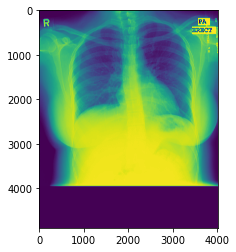

In [92]:
plt.imshow(dataset_train[0]['img'])

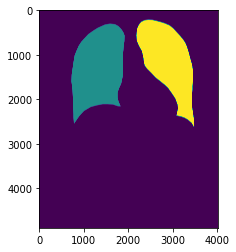

In [96]:
plt.imshow(dataset_train[0]['seg'][:,:,0] + 2*dataset_train[0]['seg'][:,:,1])

In [94]:
dataset_train[0]['seg'][:,:,0].dtype

torch.int8